# Tau_hmu regressor final training

## Import

### Import modules

In [1]:
from __future__ import division ,print_function

import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge, GaussianDropout
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import load_model
from keras import regularizers
from keras import backend as K

import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import sys
sys.path.append('../../../../modules')
from MPPlot import *
from Processors import *
#import warnings
#with warnings.catch_warnings():
#    warnings.filterwarnings('ignore')

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [2]:
mode = "mu_tau_b_b"
loc = '../../../../../data_n/'
SignalData = []
BackgroundData = []

energies = [260, 270, 280, 300, 320, 500, 550, 600 ,700]
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X

data = cleanData(data)

Samples contains 9762 signal events and 168053 background events
177815 events in total


## Configure data

### Create development and validation samples

In [3]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)


### Move to cartesian coordinates

In [4]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum


moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
addHighLvl(data)
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

### Specify variables

In [5]:

genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]


In [6]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]

other = [var for var in trainFeatures for x in ['prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi+ other]
print(trainFeatures)

['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_mass', 'diH_mass', 'diH_kinFit_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0',

In [7]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
t0Features = [var for var in trainFeatures if (str.startswith(var, "t_0"))]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in pTEtaPhi + recoFeatures + hlFeatures + t0Features]

In [8]:
regTrainFeatures_tauH = ['t_0_mass', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E',
        'mPT_px', 'mPT_py',
        'h_tt_E',
        'b_0_mass', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
        'b_1_mass', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E',
        'hl_mT',
        'h_bb_mass', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E',
        'diH_E', 'diH_|p|', 'diH_mass']
regTrainFeatures_tauMu = ['t_1_mass', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E',
        'mPT_px', 'mPT_py',
        'h_tt_E',
        'b_0_mass', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
        'b_1_mass', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E',
        'hl_mT',
        'h_bb_mass', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E',
        'diH_E', 'diH_|p|', 'diH_mass']
regTargetFeatures_tauH = ['gen_t_0_px', 'gen_t_0_py', 'gen_t_0_pz']
regTargetFeatures_tauMu = ['gen_t_1_px', 'gen_t_1_py', 'gen_t_1_pz']

In [9]:
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3705 events for training, 174101 events for validation


## Load regressors

In [10]:
name = "weights/NN_Tauh_Regressor_SO_App_" + mode + "_" 
ensembleSize = 2
tauH_ensemble = []
tauH_weights = None
tauH_inputPipe = None
tauH_outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    tauH_ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    tauH_weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    tauH_inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    tauH_outputPipe = pickle.load(fin)

In [11]:
name = "weights/NN_Taumu_Regressor_SO_App_" + mode + "_" 
ensembleSize= 2
tauMu_ensemble = []
tauMu_weights = None
tauMu_inputPipe = None
tauMu_outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    tauMu_ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    tauMu_weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    tauMu_inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    tauMu_outputPipe = pickle.load(fin)

## Response of ensemble on development data

###  Preprocess data

In [12]:
X_dev_tauH = tauH_inputPipe.transform(devData[regTrainFeatures_tauH].values.astype(theano.config.floatX))
X_dev_tauMu = tauMu_inputPipe.transform(devData[regTrainFeatures_tauMu].values.astype(theano.config.floatX))

### Get response

In [13]:
pred_tauH = np.zeros((len(devData), len(regTargetFeatures_tauH)))
for i, model in enumerate(tauH_ensemble):
    pred_tauH += tauH_weights[i]*tauH_outputPipe.inverse_transform(model.predict(X_dev_tauH, verbose=0))
pred_tauMu = np.zeros((len(devData), len(regTargetFeatures_tauMu)))
for i, model in enumerate(tauMu_ensemble):
    pred_tauMu += tauMu_weights[i]*tauMu_outputPipe.inverse_transform(model.predict(X_dev_tauMu, verbose=0))

In [14]:
for n, feature in enumerate(regTargetFeatures_tauH):
    devData['reg_' + feature[4:]] = pandas.Series(pred_tauH[:,n], index=devData.index)
for n, feature in enumerate(regTargetFeatures_tauMu):
    devData['reg_' + feature[4:]] = pandas.Series(pred_tauMu[:,n], index=devData.index)
tauMass = 1.77686
devData['reg_t_0_|p|'] = np.sqrt(np.square(devData.loc[:,'reg_t_0_px'])+np.square(devData.loc[:,'reg_t_0_py'])+np.square(devData.loc[:,'reg_t_0_pz']))
devData['reg_t_1_|p|'] = np.sqrt(np.square(devData.loc[:,'reg_t_1_px'])+np.square(devData.loc[:,'reg_t_1_py'])+np.square(devData.loc[:,'reg_t_1_pz']))
devData['reg_t_0_E'] = np.sqrt((tauMass**2)+np.square(devData.loc[:,'reg_t_0_px'])+np.square(devData.loc[:,'reg_t_0_py'])+np.square(devData.loc[:,'reg_t_0_pz']))
devData['reg_t_1_E'] = np.sqrt((tauMass**2)+np.square(devData.loc[:,'reg_t_1_px'])+np.square(devData.loc[:,'reg_t_1_py'])+np.square(devData.loc[:,'reg_t_1_pz']))
devData['reg_h_tt_px'] = devData.loc[:,'reg_t_1_px']+devData.loc[:,'reg_t_0_px']
devData['reg_h_tt_py'] = devData.loc[:,'reg_t_1_py']+devData.loc[:,'reg_t_0_py']
devData['reg_h_tt_pz'] = devData.loc[:,'reg_t_1_pz']+devData.loc[:,'reg_t_0_pz']
devData['reg_h_tt_E'] = devData.loc[:,'reg_t_1_E']+devData.loc[:,'reg_t_0_E']
devData['reg_h_tt_|p|'] = np.sqrt(np.square(devData.loc[:,'reg_h_tt_px'])+np.square(devData.loc[:,'reg_h_tt_py'])+np.square(devData.loc[:,'reg_h_tt_pz']))
devData['reg_h_tt_mass'] = np.sqrt(np.square(devData.loc[:,'reg_h_tt_E'])-np.square(devData.loc[:,'reg_h_tt_|p|']))

### Evaluate response

In [16]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    devData.loc[:, 'loss_d'] += np.square(devData.loc[devData.gen_target == 1, 'reg_' + feature[4:]]-devData.loc[:, feature])
boot = mpRun([{'data':devData[devData.gen_target == 1]['reg_h_tt_mass'].values, 'mean':1, 'std':1}])
meanReg = (np.mean(boot['_mean']), np.std(boot['_mean'])/math.sqrt(len(boot['_mean'])))
stdevReg = (np.mean(boot['_std']), np.std(boot['_std'])/math.sqrt(len(boot['_std'])))
print ('Ensemble on dev data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(devData.loc[:, 'loss_d'])/len(regTargetFeatures_tauH + regTargetFeatures_tauMu), meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))

Ensemble on dev data:
 Loss = 1069.76362408, Mean = 121.284984777 +- 0.0388758305218, sigma = 21.9324724655 +- 0.0277664592546


## Response of ensemble on validation data

###  Preprocess data

In [17]:
X_val_tauH = tauH_inputPipe.transform(valData[regTrainFeatures_tauH].values.astype(theano.config.floatX))
X_val_tauMu = tauMu_inputPipe.transform(valData[regTrainFeatures_tauMu].values.astype(theano.config.floatX))

### Get response

In [18]:
pred_tauH = np.zeros((len(valData), len(regTargetFeatures_tauH)))
for i, model in enumerate(tauH_ensemble):
    pred_tauH += tauH_weights[i]*tauH_outputPipe.inverse_transform(model.predict(X_val_tauH, verbose=0))
pred_tauMu = np.zeros((len(valData), len(regTargetFeatures_tauMu)))
for i, model in enumerate(tauMu_ensemble):
    pred_tauMu += tauMu_weights[i]*tauMu_outputPipe.inverse_transform(model.predict(X_val_tauMu, verbose=0))

In [19]:
for n, feature in enumerate(regTargetFeatures_tauH):
    valData['reg_' + feature[4:]] = pandas.Series(pred_tauH[:,n], index=valData.index)
for n, feature in enumerate(regTargetFeatures_tauMu):
    valData['reg_' + feature[4:]] = pandas.Series(pred_tauMu[:,n], index=valData.index)
tauMass = 1.77686
valData['reg_t_0_|p|'] = np.sqrt(np.square(valData.loc[:,'reg_t_0_px'])+np.square(valData.loc[:,'reg_t_0_py'])+np.square(valData.loc[:,'reg_t_0_pz']))
valData['reg_t_1_|p|'] = np.sqrt(np.square(valData.loc[:,'reg_t_1_px'])+np.square(valData.loc[:,'reg_t_1_py'])+np.square(valData.loc[:,'reg_t_1_pz']))
valData['reg_t_0_E'] = np.sqrt((tauMass**2)+np.square(valData.loc[:,'reg_t_0_px'])+np.square(valData.loc[:,'reg_t_0_py'])+np.square(valData.loc[:,'reg_t_0_pz']))
valData['reg_t_1_E'] = np.sqrt((tauMass**2)+np.square(valData.loc[:,'reg_t_1_px'])+np.square(valData.loc[:,'reg_t_1_py'])+np.square(valData.loc[:,'reg_t_1_pz']))
valData['reg_h_tt_px'] = valData.loc[:,'reg_t_1_px']+valData.loc[:,'reg_t_0_px']
valData['reg_h_tt_py'] = valData.loc[:,'reg_t_1_py']+valData.loc[:,'reg_t_0_py']
valData['reg_h_tt_pz'] = valData.loc[:,'reg_t_1_pz']+valData.loc[:,'reg_t_0_pz']
valData['reg_h_tt_E'] = valData.loc[:,'reg_t_1_E']+valData.loc[:,'reg_t_0_E']
valData['reg_h_tt_|p|'] = np.sqrt(np.square(valData.loc[:,'reg_h_tt_px'])+np.square(valData.loc[:,'reg_h_tt_py'])+np.square(valData.loc[:,'reg_h_tt_pz']))
valData['reg_h_tt_mass'] = np.sqrt(np.square(valData.loc[:,'reg_h_tt_E'])-np.square(valData.loc[:,'reg_h_tt_|p|']))

### Evaluate response

In [20]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    valData.loc[sig, 'loss_v'] += np.square(valData.loc[sig, 'reg_' + feature[4:]]-valData.loc[sig, feature])
boot = mpRun([{'data':valData[sig]['reg_h_tt_mass'].values, 'mean':1, 'std':1}])
meanReg = (np.mean(boot['_mean']), np.std(boot['_mean'])/math.sqrt(len(boot['_mean'])))
stdReg = (np.mean(boot['_std']), np.std(boot['_std'])/math.sqrt(len(boot['_std'])))
print ('Ensemble on val data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(valData.loc[sig, 'loss_v'])/len(regTargetFeatures_tauH + regTargetFeatures_tauMu), meanReg[0], meanReg[1], stdReg[0], stdReg[1]))

Ensemble on val data:
 Loss = 1263.08193686, Mean = 121.050253791 +- 0.0751032488696, sigma = 23.4930598188 +- 0.113259577803


### Momentum distributions

In [21]:
"""pltArgs = []
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.loc[sig, feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
              {'data':valData.loc[sig, feature[4:]], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
              {'data':valData.loc[sig, "reg_" + feature[4:]], 'x':xPlot, 'name':'reg_' + feature, 'kde':1}]
plots = mpRun(pltArgs)"""

ValueError: arrays must all be same length

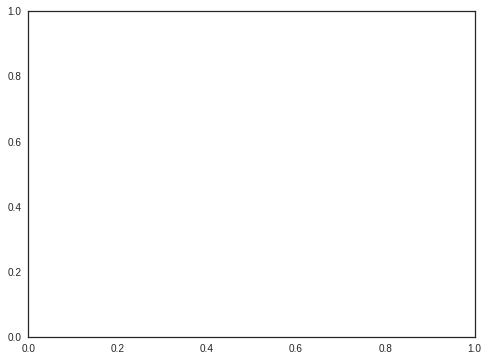

In [22]:
"""for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['reg_' + feature + '_kde'], time=xPlot, condition='Regressed', color='c')
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

### Momentum pull distributions

In [ ]:
"""pltArgs = []
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    pltArgs += [{'data':valData.loc[sig, feature[4:]]-valData.loc[sig, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.loc[sig, 'reg_' + feature[4:]]-valData.loc[sig, feature], 'x':xPlot, 'name':'reg_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

In [23]:
"""for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['reg_' + feature + '_mean']),
            np.std(plots['reg_' + feature + '_mean'])/math.sqrt(len(plots['reg_' + feature + '_mean'])))
    stdev = (np.mean(plots['reg_' + feature + '_std']),
             np.std(plots['reg_' + feature + '_std'])/math.sqrt(len(plots['reg_' + feature + '_std'])))
    print "Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['reg_' + feature + '_kde'], time=xPlot,
               condition=r'Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = "p_{x,b_0"\n    if "py" in feature:\n        var = "p_{y,b_0"\n    if "pz" in feature:\n        var = "p_{z,b_0"\n    if "_1_" in feature:\n        var = var[:-1] + "1"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,

### Two-sample Kolmogorov–Smirnov test

In [25]:
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    print ()
    print (feature)
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['reg_' + feature[4:]].values)
    print ("K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1]))


gen_t_0_px
K-S test result 0.0280, p-value of 0.8544

gen_t_0_py
K-S test result 0.0324, p-value of 0.7099

gen_t_0_pz
K-S test result 0.0280, p-value of 0.8544

gen_t_1_px
K-S test result 0.0334, p-value of 0.6708

gen_t_1_py
K-S test result 0.0345, p-value of 0.6314

gen_t_1_pz
K-S test result 0.0205, p-value of 0.9892


### Higgs mass distribution

In [26]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
bootReg = []
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['reg_h_tt_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
    
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice(valData[sig]['h_tt_mass'].values, len(valData[sig]), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
    
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
print("Distribution\t\tmean\tsigma")
print('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
print('Reconstructed Signal,  Mean = {:.2f} +- {:.2f}, sigma = {:.2f} +- {:.2f}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

Distribution		mean	sigma
Regressed Signal, Mean = 121.050253791 +- 0.0751032488696, sigma = 23.4930598188 +- 0.113259577803
Reconstructed Signal,  Mean = 137.61 +- 0.19, sigma = 58.17 +- 0.32


In [27]:
"""hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot, 
          condition=r'Reconstructed Signal,  $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),
          color='g')
sns.tsplot(data=plots['reg_kde'], time=xPlot, 
          condition=r'Regressed Signal, $\overline{M_{h\rightarrow \tau\bar{b\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanReg[0], meanReg[1], stdReg[0], stdReg[1]),
          color='c')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'hist_params = {\'shade\' : False}\nplt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'rec_kde\'], time=xPlot, \n          condition=r\'Reconstructed Signal,  $\\overline{M_{h\rightarrow \tau\x08ar{\tau}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.1f}\\pm{:.1f}$\'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),\n          color=\'g\')\nsns.tsplot(data=plots[\'reg_kde\'], time=xPlot, \n          condition=r\'Regressed Signal, $\\overline{M_{h\rightarrow \tau\x08ar{b\tau}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(meanReg[0], meanReg[1], stdReg[0], stdReg[1]),\n          color=\'c\')\nplt.legend(fontsize=16)\nplt.xlabel(r\'$M_{h\rightarrow \tau\x08ar{\tau}}\\ [GeV]$\' , fontsize=24, color=\'black\')\nplt.ylabel(r"$\x0crac{1}{N}\\ \x0crac{dN}{d M}\\ [GeV^{-1}]$", fontsize=24, color=\'black\')\nplt.show()'

In [28]:
xPlot = np.linspace(-0.5, 0.5, 500)[:, np.newaxis]
bootReg = []
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice((valData[sig]['reg_h_tt_mass'].values-125)/125, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
    
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice((valData[sig]['h_tt_mass'].values-125)/125, len(valData[sig]), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
    
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
print("Distribution\t\tmean\tsigma")
print('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
print('Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

Distribution		mean	sigma
Regressed Signal, Mean = -0.032528469943 +- 0.000667345184238, sigma = 0.187333179467 +- 0.000819954020911
Reconstructed Signal,  Mean = 0.0996504020748 +- 0.00139201553383, sigma = 0.464171884808 +- 0.00270503689064


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


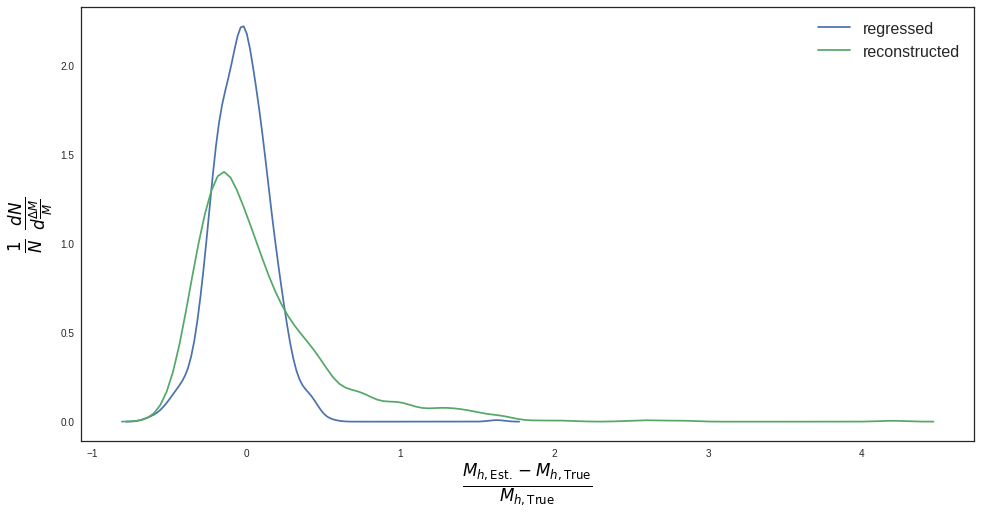

In [29]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.kdeplot(data=(valData[sig]['reg_h_tt_mass'].values-125)/125, label='regressed')
sns.kdeplot(data=(valData[sig]['h_tt_mass'].values-125)/125, label='reconstructed')
plt.legend(fontsize=16)
plt.xlabel(r"$\frac{M_{h,\mathrm{Est.}}-M_{h,\mathrm{True}}}{M_{h,\mathrm{True}}}$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\frac{\Delta M}{M}}$", fontsize=24, color='black')
plt.show()

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


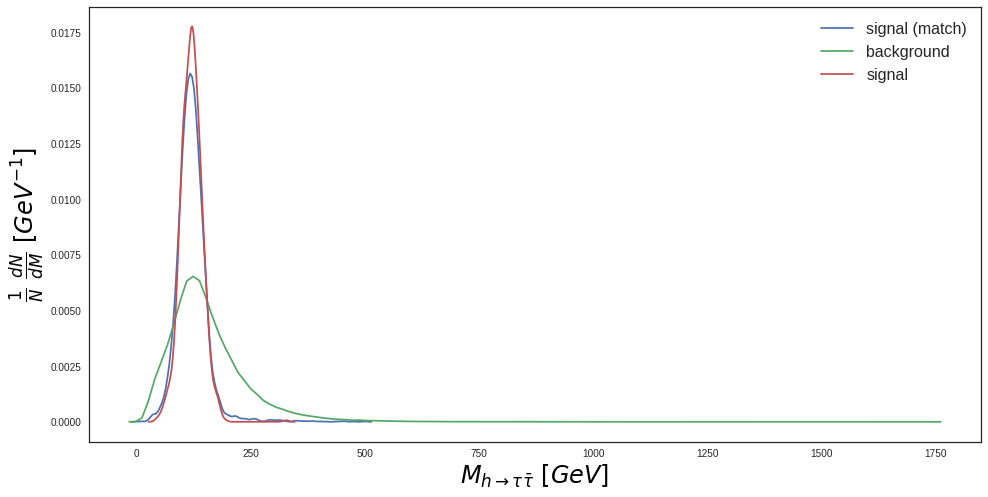

In [30]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[sigMM, 'reg_h_tt_mass'].values, label = 'signal (match)')
sns.kdeplot(data=valData.loc[bkg, 'reg_h_tt_mass'].values, label = 'background')
sns.kdeplot(data=valData.loc[sig, 'reg_h_tt_mass'].values, label = 'signal')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [31]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[bkg, 'h_tt_mass'], 'x':xPlot, 'name':'bkg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[bkg, 'reg_h_tt_mass'], 'x':xPlot, 'name':'bkg_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'h_tt_mass'], 'x':xPlot, 'name':'sig', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'reg_h_tt_mass'], 'x':xPlot, 'name':'sig_reg', 'kde':1, 'mean':1, 'std':1}])

In [32]:
meanReco = (np.mean(plots['sig' + '_mean']),
            np.std(plots['sig' + '_mean'])/math.sqrt(len(plots['sig' + '_mean'])))
stdReco = (np.mean(plots['sig' + '_std']),
             np.std(plots['sig' + '_std'])/math.sqrt(len(plots['sig' + '_std'])))
meanReg = (np.mean(plots['sig_reg' + '_mean']),
            np.std(plots['sig_reg' + '_mean'])/math.sqrt(len(plots['sig_reg' + '_mean'])))
stdReg = (np.mean(plots['sig_reg' + '_std']),
             np.std(plots['sig_reg' + '_std'])/math.sqrt(len(plots['sig_reg' + '_std'])))

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


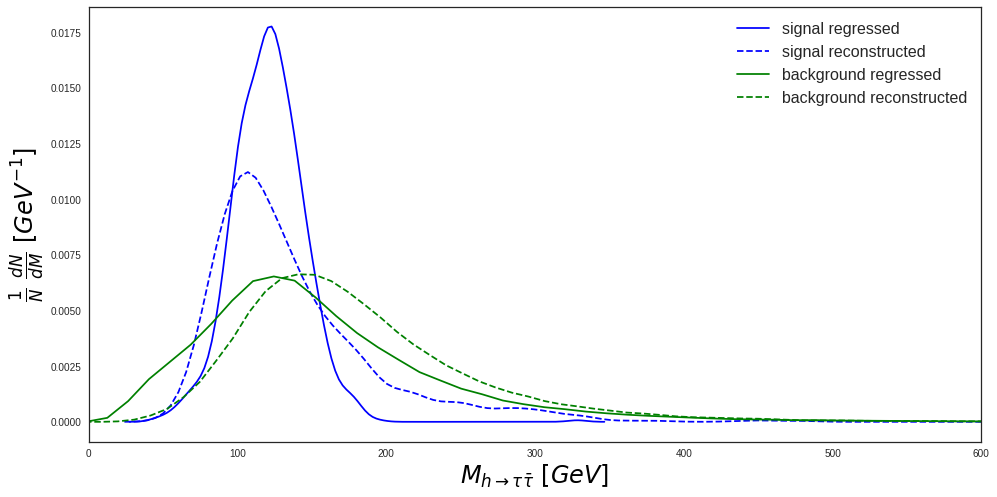

In [33]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[sig, 'reg_h_tt_mass'].values, label='signal regressed',color = 'blue')
sns.kdeplot(data=valData.loc[sig, 'h_tt_mass'].values, label='signal reconstructed',color = 'blue' , ls = 'dashed')
sns.kdeplot(data=valData.loc[bkg, 'reg_h_tt_mass'].values, label='background regressed',color = 'green' )
sns.kdeplot(data=valData.loc[bkg, 'h_tt_mass'].values, label='background reconstructed',color = 'green' , ls = 'dashed')
plt.xlim(0,600)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### ROC Curve

In [34]:
print 'Reg:', roc_auc_score(valData.loc[sig|bkg, 'gen_target'], -np.abs(125-valData.loc[sig|bkg, 'reg_h_tt_mass']))
print 'Reco:', roc_auc_score(valData.loc[sig|bkg, 'gen_target'], -np.abs(125-valData.loc[sig|bkg, 'h_tt_mass']))

SyntaxError: invalid syntax (<ipython-input-34-b65e13524c17>, line 1)

In [ ]:
sns.distplot(-np.abs(125-valData.loc[sig, 'reg_h_tt_mass']), label='signal')
sns.distplot(-np.abs(125-valData.loc[bkg, 'reg_h_tt_mass']), label='bkg')
plt.legend()

## Classifier response

### Train

In [ ]:
classFeatures = ['t_0_mass',
                 't_1_mass',
                 'b_0_mass', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_E', 'b_0_|p|',
                 'b_1_mass', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_E', 'b_1_|p|',
                 'mPT_px', 'mPT_py',
                 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_mass', 'h_bb_E', 'h_bb_|p|',
                 'diH_px', 'diH_py', 'diH_pz', 'diH_mass', 'diH_E', 'diH_|p|',
                 'hl_mT']

In [ ]:
recoFeatures = ['h_tt_mass']
recoFeatures += ['t_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E',
                 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E',
                 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E']
recoFeatures += classFeatures
print len(recoFeatures), "Training features"
recoClass = XGBoostClassifier()
recoClass.fit(devData[recoFeatures], devData['gen_target'].values.astype('int'))

In [ ]:
regFeatures = ['reg_h_tt_mass']
regFeatures += ['reg_t_0_px', 'reg_t_0_py', 'reg_t_0_pz', 'reg_t_0_|p|', 'reg_t_0_E',
                'reg_t_1_px', 'reg_t_1_py', 'reg_t_1_pz', 'reg_t_1_|p|', 'reg_t_1_E',
                'reg_h_tt_px', 'reg_h_tt_py', 'reg_h_tt_pz', 'reg_h_tt_|p|', 'reg_h_tt_E']
regFeatures += classFeatures
print len(regFeatures), "Training features"
regClass = XGBoostClassifier()
regClass.fit(devData[regFeatures], devData['gen_target'].values.astype('int'))

### Test

In [ ]:
recoPred = [recoClass.predict_proba(devData[recoFeatures])[:,1],
            recoClass.predict_proba(valData[recoFeatures])[:,1]]

In [ ]:
regPred = [regClass.predict_proba(devData[regFeatures])[:,1],
           regClass.predict_proba(valData[regFeatures])[:,1]]

In [ ]:
recoAUC = [roc_auc_score(devData['gen_target'].values, recoPred[0]),
           roc_auc_score(valData['gen_target'].values, recoPred[1])]
regAUC = [roc_auc_score(devData['gen_target'].values, regPred[0]),
          roc_auc_score(valData['gen_target'].values, regPred[1])]

In [ ]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(devData['gen_target'].values, recoPred[0])[:2],
         label=r'Reco Dev, $auc={:.4f}$'.format(recoAUC[0]), linestyle='dashed', color='g')
plt.plot(*roc_curve(valData['gen_target'].values, recoPred[1])[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC[1]), color='g')
plt.plot(*roc_curve(devData['gen_target'].values, regPred[0])[:2],
         label=r'Reg Dev, $auc={:.4f}$'.format(regAUC[0]), linestyle='dashed', color='b')
plt.plot(*roc_curve(valData['gen_target'].values, regPred[1])[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC[1]), color='b')
#plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=24)
plt.show()